In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,GRU, LSTM, Dense, Bidirectional,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from wordcloud import WordCloud,STOPWORDS
import os

In [54]:
lyrics=open('lyrics.txt').read()
print(lyrics[0:100])

Come all ye maidens young and fair
And you that are blooming in your prime
Always beware and keep yo


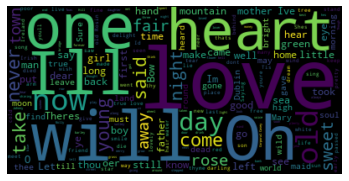

In [55]:
stopwords=set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(lyrics)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [56]:
tokenizer=Tokenizer()
corpus=lyrics.lower().split(',')
tokenizer.fit_on_texts(corpus)
total_words=len(tokenizer.word_index)+1
print(total_words)

2690


In [57]:
input_sequences=[]
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range (1,len(token_list)):
        n_gram_seqeuence = token_list[:i+1]
        input_sequences.append(n_gram_seqeuence)

In [58]:
max_sequence_len=max([len(x) for x in input_sequences])
input_sequences=np.array(pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre'))

In [59]:
xs=input_sequences[:,:-1]
labels=input_sequences[:,-1]

In [60]:
ys = tf.keras.utils.to_categorical(labels,num_classes=total_words)

In [72]:
model=Sequential()
model.add(Embedding(total_words,240,input_length=max_sequence_len-1))
model.add(LSTM(150,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(total_words,activation='softmax'))
adam=Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history=model.fit(xs,ys,epochs=20,batch_size=64,verbose=1)

Epoch 1/20


ValueError: in user code:

    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:797 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1644 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/gb/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 2690) and (None, 281, 2690) are incompatible


In [14]:
model.save('weights1.h5')

In [73]:
model=load_model('weights1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 240)           645600    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 150)           234600    
_________________________________________________________________
dropout (Dropout)            (None, 15, 150)           0         
_________________________________________________________________
gru (GRU)                    (None, 75)                51075     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense (Dense)                (None, 2690)              204440    
Total params: 1,135,715
Trainable params: 1,135,715
Non-trainable params: 0
______________________________________________

In [83]:
seed_text='Stairway to heaven'
orignal_text=seed_text
next_words=5
for i in range(next_words):
   text = []
   for _ in range(100):
     tonken_list = tokenizer.texts_to_sequences([seed_text])
     tonken_list = pad_sequences(tonken_list, maxlen=max_sequence_len, padding='pre')
     predicted = np.argmax(model.predict(tonken_list), axis=-1)
     output_word = ""
     for word, index in tokenizer.word_index.items():
       if index == predicted:
         output_word = word
         break
     seed_text = seed_text + ' ' + output_word
     text.append(output_word)
   seed_text = text[-1]
   text = ' '.join(text)
print(orignal_text+' '+text)

Stairway to heaven the new land and the high land and the high land and the high and him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him make him to the heart for the heart and the heart for a heart for the love to the covers and the and the covers buttoned and the covers buttoned the and buttoned and the covers buttoned and the covers buttoned and the covers buttoned and the covers buttoned and the covers buttoned
